In [74]:
import re

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp

In [2]:
# Data source: https://www.kaggle.com/c/titanic/data
df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")

In [3]:
df_train.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [4]:
df_test.head(10)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
5,897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,9.2250,NaN,S
6,898,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.6292,NaN,Q
7,899,2,"Caldwell, Mr. Albert Francis",male,26.0,1,1,248738,29.0000,NaN,S
8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.0,0,0,2657,7.2292,NaN,C
9,901,3,"Davies, Mr. John Samuel",male,21.0,2,0,A/4 48871,24.1500,NaN,S


## Define Data Types

Target:
* Survived

Categorical:
* Pclass: Though it is an ordinal variable, I will treat it as categorical, because there is only 3 levels, and the dependency is probably non-liner
* Sex
* Embarked

Numerical:
* Age
* SibSp
* Parch
* Fare

Text:
* Name: Some features can be created from it
* Cabin: Some features can be created from it

Unused:
* PassengerId: Obviously ID's are not useful for classification
* Ticket: For the first sight I don't see any useful info in it

In [7]:
label_name = "Survived"

categorical_feature_names = ["Pclass", "Sex", "Embarked"]
numerical_feature_names = ["Age", "SibSp", "Parch", "Fare"]
text_feature_names = ["Name", "Cabin"]

## Missing Values

Ratio of missing values of columns:
PassengerId    0.000000
Survived       0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.198653
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.000000
Cabin          0.771044
Embarked       0.002245
dtype: float64


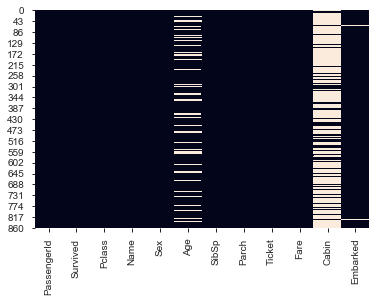

Ratio of missing values of columns:
PassengerId    0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.205742
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.002392
Cabin          0.782297
Embarked       0.000000
dtype: float64


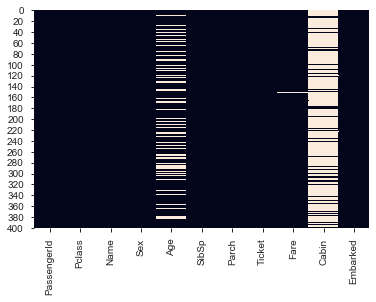

In [9]:
def inspect_missing(df):
    dataset_size = df.shape[0]
    print("Ratio of missing values of columns:")
    print(df.isnull().sum() / dataset_size)
    sns.heatmap(df.isnull(), cbar=False)
    plt.show()

inspect_missing(df_train)

inspect_missing(df_test)

* Age has a considerable amount of missing values (20% in training set)
* Cabin has a lot of missing values (77% in training set)
* Embarked has a small amount of missing values (0.22%) in training set
* Fare has a small amount of missing values (0.24%) in test set
* The distribution of missing values is even

We can add new features to signal if cabin or age is missing, maybe this is correlating with the target variable

In [11]:
df_train["Cabin_missing"] = df_train["Cabin"].isna()
df_train["Age_missing"] = df_train["Age"].isna()

categorical_feature_names += ["Cabin_missing", "Age_missing"]

# Exploratory Data Analysis / Feature Engineering

## Women and children first

For the next section it worths understanding the quote "Women and children first".

The phrase was popularised by its usage on the RMS Titanic. The Second Officer suggested to Captain Smith, "Hadn't we better get the women and children into the boats, sir?", to which the captain responded: "put the women and children in and lower away". The First (Officer Murdoch) and Second (Officer Lightoller) officers interpreted the evacuation order differently; Murdoch took it to mean women and children first, while Lightoller took it to mean women and children only. Second Officer Lightoller lowered lifeboats with empty seats if there were no women and children waiting to board, while First Officer Murdoch allowed a limited number of men to board if all the nearby women and children had embarked.

Source: [Wikipedia](https://en.wikipedia.org/wiki/Women_and_children_first)

## Helper Functions

In [130]:
def explore_binary(series):
    print("Ratio: {}".format(series.mean()))

    
def dependency_categorical(feature, label, binned=False):
    """ Makes a crosstabulation between categorical feature and label """
    # Calculate crosstab and counts
    df_crosstab = pd.crosstab(feature, label)
    counts = df_crosstab.sum(axis=1)
    df_crosstab = df_crosstab.divide(counts, axis=0)
    df_crosstab["Count"] = counts
    # Sorting
    if binned:
        df_crosstab["Bin_left"] = [x.left for x in df_crosstab.index.values]
        df_crosstab = df_crosstab.sort_values("Bin_left")
        df_crosstab = df_crosstab.drop("Bin_left", axis=1)
    else:
        df_crosstab = df_crosstab.sort_values("Count", ascending=False)
    # Printing
    print(df_crosstab)

    
def dependency_numerical_small(df, feature_name):
    df_groupped = df.groupby(feature_name).agg({
        label_name: {"Sum": "sum", "Count": "count"},
    })
    df_groupped["Count"] = df_groupped[(label_name, "Count")]
    df_groupped["Survival_ratio"] = df_groupped[(label_name, "Sum")] / df_groupped[(label_name, "Count")]
    df_groupped = df_groupped.drop(label_name, axis=1)
    print(df_groupped)

    
def dependency_numerical(df, feature_name, label_name):
    df_pairplot = df[[feature_name, label_name]].dropna()
    feature_negative = df_pairplot[df_pairplot[label_name] == 0][feature_name]
    feature_positive = df_pairplot[df_pairplot[label_name] == 1][feature_name]
    # Distribution plots
    sns.distplot(feature_negative, kde=True, label="Perished")
    sns.distplot(feature_positive, kde=True, label="Survived")
    plt.legend()
    plt.show()
    # Describe
    print("Describe {}".format(feature_name))
    print(df[feature_name].describe(percentiles=np.linspace(0.1, 0.9, 9)))
    # Kolmogorov–Smirnov test
    d_val, p_val = ks_2samp(feature_negative, feature_positive)
    print("")
    print("Two sample Kolmogorov–Smirnov test for {}".format(feature_name))
    print("D value: {} p value: {}".format(d_val, p_val))

# This column will help count rows after groupby
df_train["Count"] = 1

## Label

In [18]:
print("Survived")
explore_binary(df_train[label_name])

Survived
Ratio: 0.3838383838383838


There is no huge imbalance in the labels.

## Pclass

In [14]:
dependency_categorical(df_train["Pclass"], df_train[label_name])

Survived         0         1  Count
Pclass                             
3         0.757637  0.242363    491
1         0.370370  0.629630    216
2         0.527174  0.472826    184


* The third class tickets are in majority
* The higher the class number, the lower the survival ratio, as expected

## Sex

In [19]:
dependency_categorical(df_train["Sex"], df_train[label_name])

Survived         0         1  Count
Sex                                
male      0.811092  0.188908    577
female    0.257962  0.742038    314


* The majority of pessengers are males
* The survival ratio of females (74%) is significantly higher than of males (19%)

## Embarked

In [20]:
dependency_categorical(df_train["Embarked"], df_train[label_name])

Survived         0         1  Count
Embarked                           
S         0.663043  0.336957    644
C         0.446429  0.553571    168
Q         0.610390  0.389610     77


Passengers were boarding the Titanic from 3 different cities in Europe, before heading off to New York: Southampton (England) encoded as `S`, Cherbourg (France) encoded as `C` and Queenstown (Ireland) encoded as `Q`.

* Most of the passengers embarked in Southampton
* The port of embarkation explains some variance
    * Does the port really matter?
    * Does this feature only correlate to other features, that cause this effect?
    * Does the port contain some information that can't be explained by the other features?
    * We will have to answer these questions later

## Age

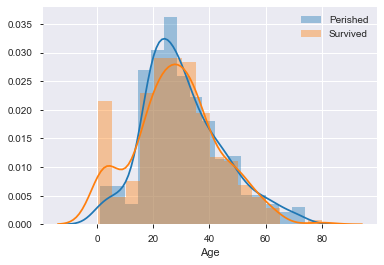

Describe Age
count    714.000000
mean      29.699118
std       14.526497
min        0.420000
10%       14.000000
20%       19.000000
30%       22.000000
40%       25.000000
50%       28.000000
60%       31.800000
70%       36.000000
80%       41.000000
90%       50.000000
max       80.000000
Name: Age, dtype: float64

Two sample Kolmogorov–Smirnov test for Age
D value: 0.08877683799609629 p value: 0.12277292350653957


In [103]:
dependency_numerical(df_train, "Age", label_name)

Let's bin age and investigate what is the survival rate in each bin.

In [109]:
df_train["Age_binned_explore"] = pd.cut(df_train["Age"], 20)
dependency_categorical(df_train["Age_binned_explore"], df_train[label_name], binned=True)

Survived                   0         1  Count
Age_binned_explore                           
(0.34, 4.399]       0.325000  0.675000     40
(4.399, 8.378]      0.357143  0.642857     14
(8.378, 12.357]     0.733333  0.266667     15
(12.357, 16.336]    0.516129  0.483871     31
(16.336, 20.315]    0.658228  0.341772     79
(20.315, 24.294]    0.632653  0.367347     98
(24.294, 28.273]    0.647059  0.352941     85
(28.273, 32.252]    0.583333  0.416667     84
(32.252, 36.231]    0.520548  0.479452     73
(36.231, 40.21]     0.622222  0.377778     45
(40.21, 44.189]     0.657143  0.342857     35
(44.189, 48.168]    0.657143  0.342857     35
(48.168, 52.147]    0.517241  0.482759     29
(52.147, 56.126]    0.562500  0.437500     16
(56.126, 60.105]    0.615385  0.384615     13
(60.105, 64.084]    0.636364  0.363636     11
(64.084, 68.063]    1.000000  0.000000      4
(68.063, 72.042]    1.000000  0.000000      5
(72.042, 76.021]    1.000000  0.000000      1
(76.021, 80.0]      0.000000  1.00

* Age explains some variance
* Children (from 0 to 16 years old) have higher 

In [111]:
print(df_train[df_train["Age"] < 1]["Age"].tolist())

[0.83, 0.92, 0.75, 0.75, 0.67, 0.42, 0.83]


Age has a few fraction numbers in it, like 0.42, 0.67. Maybe they are mistypes of and actually mean 42 and 67, or they are indeed infants with age below 1 years. Since there is no way of knowing and there is only a low amount of shuch passengers, I will just leave them as they are.

## Ticket

In [136]:
print("Number of unique tickets: {}".format(len(df_train["Ticket"].unique())))

Number of unique tickets: 681


After some reading it turned out that multiple pessengers can travel with the same ticket number. It means that they are travelling together.

In [142]:
df_pessenger_per_ticket = (
    df_train
    .groupby("Ticket")
    .agg({"Count": "count"})
    .reset_index()
    .rename({"Count": "Passenger_per_ticket"}, axis=1)
)
df_train = df_train.merge(df_pessenger_per_ticket, on="Ticket", how="left")

In [143]:
dependency_numerical_small(df_train, "Passenger_per_ticket")

                     Count Survival_ratio
                                         
Passenger_per_ticket                     
1                      547       0.297989
2                      188       0.574468
3                       63       0.698413
4                       44       0.500000
5                       10       0.000000
6                       18       0.000000
7                       21       0.238095


## Fare

After some reading it turned out that the fare is calculated per ticket number, not per person, so we will have to normalize with the number of tickets.

Calculate perssenger number per ticket:

In [144]:
df_train["Fare_per_person"] = df_train["Fare"] / df_train["Passenger_per_ticket"]

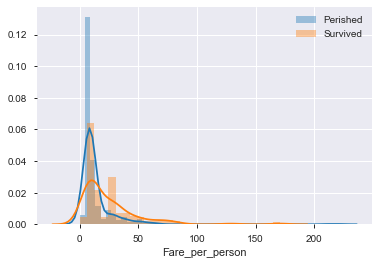

Describe Fare_per_person
count    891.000000
mean      17.788989
std       21.218157
min        0.000000
10%        7.050000
20%        7.733300
30%        7.854200
40%        8.050000
50%        8.850000
60%       11.725000
70%       14.500000
80%       26.550000
90%       39.400000
max      221.779200
Name: Fare_per_person, dtype: float64

Two sample Kolmogorov–Smirnov test for Fare_per_person
D value: 0.31310516728980925 p value: 2.6645352591003757e-15


In [145]:
dependency_numerical(df_train, "Fare_per_person", label_name)

In [147]:
df_train["Fare_binned_explore"] = pd.qcut(df_train["Fare_per_person"], 5)
dependency_categorical(df_train["Fare_binned_explore"], df_train[label_name], binned=True)

Survived                    0         1  Count
Fare_binned_explore                           
(-0.001, 7.733]      0.783333  0.216667    180
(7.733, 8.05]        0.743119  0.256881    218
(8.05, 11.725]       0.659420  0.340580    138
(11.725, 26.55]      0.513228  0.486772    189
(26.55, 221.779]     0.349398  0.650602    166


In [60]:

dependency_numerical_small(df_train, "SibSp")
dependency_numerical_small(df_train, "Parch")

      Count Survival_ratio
                          
SibSp                     
0       608       0.345395
1       209       0.535885
2        28       0.464286
3        16       0.250000
4        18       0.166667
5         5       0.000000
8         7       0.000000
      Count Survival_ratio
                          
Parch                     
0       678       0.343658
1       118       0.550847
2        80       0.500000
3         5       0.600000
4         4       0.000000
5         5       0.200000
6         1       0.000000


## Ticket

In [128]:
len(df_train["Ticket"].unique())
df_train[df_train["Fare"] > 200].sort_values("Ticket")[["Survived", "Pclass", "Name", "Age", "SibSp", "Parch", "Ticket", "Fare", "Cabin", "Embarked"]].head(20)

,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
377,0,1,"Widener, Mr. Harry Elkins",27.0,0,2,113503,211.5000,C82,C
27,0,1,"Fortune, Mr. Charles Alexander",19.0,3,2,19950,263.0000,C23 C25 C27,S
341,1,1,"Fortune, Miss. Alice Elizabeth",24.0,3,2,19950,263.0000,C23 C25 C27,S
438,0,1,"Fortune, Mr. Mark",64.0,1,4,19950,263.0000,C23 C25 C27,S
88,1,1,"Fortune, Miss. Mabel Helen",23.0,3,2,19950,263.0000,C23 C25 C27,S
689,1,1,"Madill, Miss. Georgette Alexandra",15.0,0,1,24160,211.3375,B5,S
730,1,1,"Allen, Miss. Elisabeth Walton",29.0,0,0,24160,211.3375,B5,S
779,1,1,"Robert, Mrs. Edward Scott (Elisabeth Walton Mc...",43.0,0,1,24160,211.3375,B3,S
527,0,1,"Farthing, Mr. John",NaN,0,0,PC 17483,221.7792,C95,S
299,1,1,"Baxter, Mrs. James (Helene DeLaudeniere Chaput)",50.0,0,1,PC 17558,247.5208,B58 B60,C
